![Edem_Logo](https://n3m5z7t4.rocketcdn.me/wp-content/plugins/edem-shortcodes/public/img/logo-Edem.png)

# Serverless Data Processing

##### This notebook will be our first contact with **Apache Beam** where we will put into practice the concepts seen in the theory:

* PCollection & PTransform
* DoFn vs Other methods
* DoFn Life Cycle
* Streaming Concepts

<img src="https://miro.medium.com/max/1000/1*Iax0FeSxRIk22L_TbmVWXQ.jpeg" style="width: 200px; height:150px;">

## 00 | Setup

Before we start, we need to **authenticate** in Google Cloud Platform. It is important that when launching the cell we are logged into colab with the **same Google user** that we have used in the registration in GCP.

In [6]:
#@title Authenticate GCP

from google.colab import auth
auth.authenticate_user()

In [ ]:
#@title Install requirements
!pip install apache_beam[interactive]

In [ ]:
#@title Import Common libraries
import logging
import apache_beam as beam
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
import apache_beam.runners.interactive.interactive_beam as ib

## 01. Beam Basics

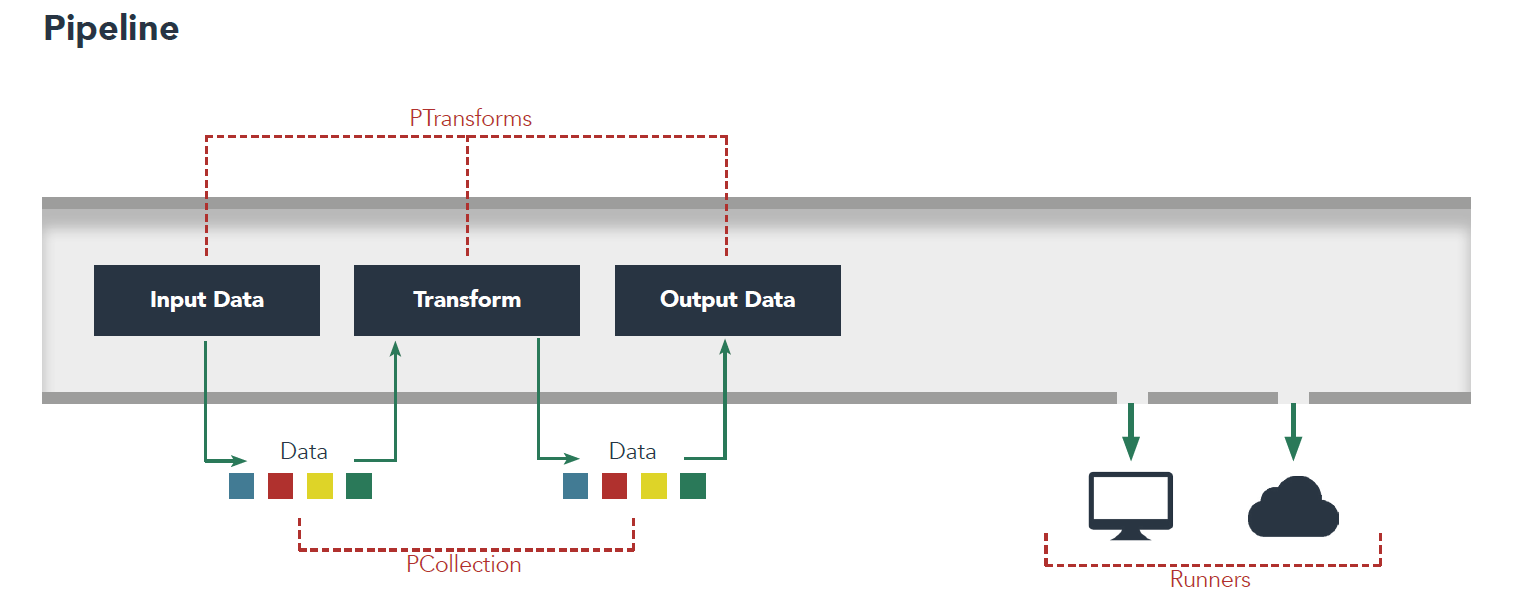

### Understanding basic concepts: PCollection, PTransform & Pipeline Object

Creating our first Beam Pipeline

In [ ]:
#Create the Pipeline Object
with beam.Pipeline(InteractiveRunner()) as p:
  #In order to get our first collection, we will create an I/O PTransform
  PColl_01 = p | "Read Input File" >> beam.io.ReadFromText('/content/input_text.txt')
  #Our second PCollection will be used to split the text into words.
  PColl_02 = PColl_01 | "Split words" >> beam.FlatMap(lambda x: x.split())
  #Our third collection will pair the word with 1.
  PColl_03 = PColl_02 | "Pair words" >> beam.Map(lambda x: (x,1))
  #Finally, CombinePerKey allows us to get the number of times a word appears.
  PColl_04 = PColl_03 | "Count" >> beam.CombinePerKey(sum)
  #Print results
  PColl_04 | beam.Map(print)

### Understanding basic concepts: DoFn vs Map

The goal of this second exercise is to see how DoFn methods are still full versions of the methods we have used before

In [ ]:
#Method
def mult(element, num):
  return element * num

#DoFn
class mult_new(beam.DoFn):
  def process(self, element, num):
    yield element * num

#Pipeline
with beam.Pipeline(InteractiveRunner()) as p:
  input_data = (
      p 
        | "Create a PCollection" >> beam.Create([1,2,3,4,5])
        | "Map" >> beam.Map(mult, num=5)
        #| "DoFn" >> beam.ParDo(mult_new(),5)
  )

In [ ]:
#Show PCollection
ib.show(input_data)

### Exercise: Removes all punctuation symbols from the previous exercise.

In [ ]:
#YOUR_CODE

### Understanding DoFN Life Cycle

The third exercise will show the DoFn LifeCycle and how it will always be computed even if we vary the order of the methods within the class.

In [ ]:
from datetime import datetime

class DoFnLifeCycle(beam.DoFn):

  def now(self):
    self._now = datetime.now()
    return self._now

  def __init__(self):
    print("Constructor started at: %s" % self.now())

  def setup(self):
    print("worker started at: %s" % self.now())

  def start_bundle(self):
    print("bundle started at: %s" % self.now())

  def process(self, element):
    words = element.split()
    for word in words:
      print("Processing element: %s" % word)
      yield word.upper()

  def finish_bundle(self):
    print("bundle finished at: %s" % self.now())

  def teardown(self):
    print("worker finished at: %s" % self.now())

with beam.Pipeline(InteractiveRunner()) as p:
  input_data = (
      p 
        | "Reading the input file" >> beam.io.ReadFromText('/content/input_text.txt')
        | "DoFn Life Cycle" >> beam.ParDo(DoFnLifeCycle())
  )

### Understanding the different ways to set our transformations

The goal at this point is to check how we can perform the same operations and how we can better organize our code.

In [ ]:
#Method
def mult(element):
  return element * 2

#DoFn
class mult_new(beam.DoFn):
  def process(self, element, num):
    yield element * num

#PTransform
class mult_transform(beam.PTransform):
  def expand(self, PColl):
    PColl_test = PColl | "Pair" >> beam.Map(lambda x: (x,1))
    yield PColl_test

#Pipeline
with beam.Pipeline(InteractiveRunner()) as p:
  input_data = (
      p 
        | "Create a PCollection" >> beam.Create([1,2,3,4,5])
        | "Map" >> beam.Map(mult)
        | "DoFn" >> beam.ParDo(mult_new(),5)
  )

  output_data = input_data | mult_transform()

### GCP: Streaming Pipeline Demo

In [4]:
#Uninstall apache_beam[interactive]
!pip uninstall apache_beam[interactive]
#Install apache_beam[gcp]
!pip install apache_beam[gcp]

Found existing installation: apache-beam 2.44.0
Uninstalling apache-beam-2.44.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/apache_beam-2.44.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/apache_beam/*
Proceed (Y/n)? y
  Successfully uninstalled apache-beam-2.44.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached apache_beam-2.44.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.6 MB)


In [ ]:
#Create a PubSub Topic
!gcloud pubsub topics create mytopic --project spa-datajuniorsprogram-sdb-001

In [25]:
#Create a PubSub Subscription
!gcloud pubsub subscriptions create mysub --topic mytopic --project spa-datajuniorsprogram-sdb-001

Created subscription [projects/spa-datajuniorsprogram-sdb-001/subscriptions/mysub].


In [ ]:
#Create a BigQuery Dataset
!bq mk --location EU <PROJECT_ID>:<DATASET_NAME>

In [2]:
#Input vars
project_id = "spa-datajuniorsprogram-sdb-001"
dataset = "testDataset"
table = "testTable"
subscription_name = "mysub"

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io.gcp import bigquery_tools
import json

#Parse PubSub Messages
def parsePubSubMessages(message):
  msg = message.data.decode('utf-8')
  row = json.loads(msg)
  return row

#BigQuery Schema
input_schema = {
    "fields": [
    {
      "mode": "NULLABLE",
      "name": "Amount",
      "type": "STRING"
    },
    {
      "mode": "NULLABLE",
      "name": "Timestamp",
      "type": "STRING"
    }]
}

schema = bigquery_tools.parse_table_schema_from_json(json.dumps(input_schema))

#Pipeline Options
options = PipelineOptions(streaming=True)
with beam.Pipeline(options=options) as p:
  data = (
      p 
          | "Read messages from PubSub" >> beam.io.ReadFromPubSub(subscription=f"projects/{project_id}/subscriptions/{subscription_name}", with_attributes=True)
          | "Parse JSON messages" >> beam.Map(parsePubSubMessages)
          | "Write BQ" >> beam.io.WriteToBigQuery(
              table = f"{project_id}:{dataset}.{table}",
              schema = schema,
              create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
              write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND
          )
  )